In [33]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

In [34]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [35]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

In [36]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform
  

In [38]:
#wav_file_name = 'speech_whistling2.wav'
#wav_file_name = 'miaow_16k.wav'
wav_file_name = 'm1887_fire1.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 4.86s
Size of the input: 77760


In [19]:
waveform = wav_data / tf.int16.max

In [20]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

In [21]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Whistle


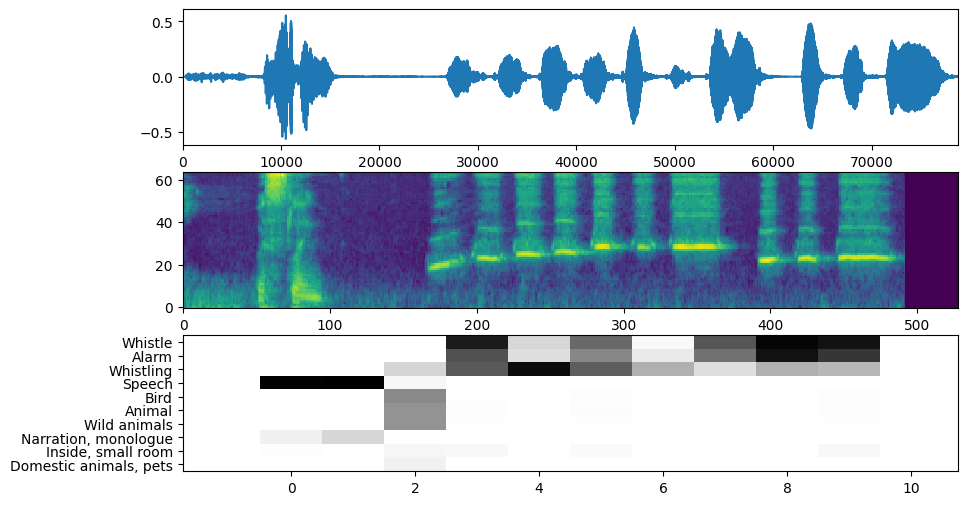

In [22]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))